In [1]:
!nvidia-smi

Sun Nov 20 02:37:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!mkdir ~/.kaggle/ && mv kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangsienicajzkowy/afo-aerial-dataset-of-floating-objects
!unzip afo-aerial-dataset-of-floating-objects.zip && rm afo-aerial-dataset-of-floating-objects.zip

Streaming output truncated to the last 5000 lines.
  inflating: PART_1/PART_1/6categories/s1_145.txt  
  inflating: PART_1/PART_1/6categories/s1_146.txt  
  inflating: PART_1/PART_1/6categories/s1_147.txt  
  inflating: PART_1/PART_1/6categories/s1_148.txt  
  inflating: PART_1/PART_1/6categories/s1_149.txt  
  inflating: PART_1/PART_1/6categories/s1_15.txt  
  inflating: PART_1/PART_1/6categories/s1_150.txt  
  inflating: PART_1/PART_1/6categories/s1_151.txt  
  inflating: PART_1/PART_1/6categories/s1_152.txt  
  inflating: PART_1/PART_1/6categories/s1_153.txt  
  inflating: PART_1/PART_1/6categories/s1_154.txt  
  inflating: PART_1/PART_1/6categories/s1_155.txt  
  inflating: PART_1/PART_1/6categories/s1_156.txt  
  inflating: PART_1/PART_1/6categories/s1_157.txt  
  inflating: PART_1/PART_1/6categories/s1_158.txt  
  inflating: PART_1/PART_1/6categories/s1_159.txt  
  inflating: PART_1/PART_1/6categories/s1_16.txt  
  inflating: PART_1/PART_1/6categories/s1_160.txt  
  inflating: PA

In [29]:
! pip -q install pybboxes

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import pybboxes as pbx
from pprint import pprint
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


path = './PART_1/PART_1/'
path2catgory1 = './PART_1/PART_1/1category'
path2images = './PART_1/PART_1/images/'

In [2]:
data = os.listdir(os.path.join(path, 'images'))
df = pd.DataFrame({
    "images": data
})
df['dir_path'] = path
df['path2img'] = df['dir_path'] + '/' + df['images']

In [3]:
list_of_imgs = sorted(df['images'].apply(lambda x: x[:-4]).tolist())

`1category` contains bounding box coordinates for all images

In [4]:
category_one_data = os.listdir(os.path.join(path, '1category'))
category_one_df = pd.DataFrame({
    "1category": sorted(category_one_data)
})
print(category_one_df.shape)
category_one_df.head()

(3641, 1)


1category
0   a_101.txt
1  a_1013.txt
2  a_1014.txt
3  a_1015.txt
4  a_1016.txt

`images` in `part1` only contain `1/3` of all images

the rest of the 2/3 of images are in `part2` and `part3`

so we need to filter out only the bounding box coordinates for images in `part1` from `1category`


In [5]:
list_of_1category_labels = category_one_df['1category'].apply(lambda x: x[:-4]).tolist()
filtered_1category_labels = sorted(list(set(list_of_1category_labels).intersection(list_of_imgs)))
len(filtered_1category_labels)

1014

In [6]:
data = filtered_1category_labels.copy()
filtered_1category_labels_df = pd.DataFrame({
    '1category': data
})
filtered_1category_labels_df['1category'] = filtered_1category_labels_df['1category'].apply(lambda x: x+'.txt')
filtered_1category_labels_df.head()

1category
0   a_101.txt
1  a_1013.txt
2  a_1014.txt
3  a_1015.txt
4  a_1016.txt

In [7]:
print(len(os.listdir(path2catgory1)))

3641


In [8]:
# for one .txt file
x = pd.read_csv(os.path.join(path2catgory1, 'a_101.txt'), sep=" ", header=None).drop([0], axis=1).rename(columns={1: "x", 2: "y", 3: "w", 4: "h"})
target_cols = ['x', 'y', 'w', 'h']
bbox_targs = x[target_cols].values.tolist()

In [9]:
# https://stackoverflow.com/questions/36133716/how-to-skip-reading-empty-files-with-panda-in-python
def is_non_zero_file(fpath):  
    """check if file is empty"""
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0

path = os.path.join(path2catgory1, 'a_122.txt')
is_non_zero_file(path)

False

iterate through `1category` and extract the bounding box coordinates + the filename

In [10]:
data = sorted(os.listdir(path2catgory1))
category1length = len(os.listdir(path2catgory1))
target_cols = ['x', 'y', 'w', 'h']
tmp_arr = []
filename_arr = []

for i in tqdm(range(category1length), total=category1length):
    file = data[i]
    filename_arr.append(file)
    filepath = os.path.join(path2catgory1, file)
    if not is_non_zero_file(filepath):
        tmp_arr.append('[]')
        continue
    else:
        tmp_df = pd.read_csv(os.path.join(path2catgory1, file), sep=" ", header=None).drop([0], axis=1).rename(columns={1: "x", 2: "y", 3: "w", 4: "h"})
        bbox_targs = tmp_df[target_cols].values.tolist()
        tmp_arr.append(bbox_targs)

100%|██████████| 3641/3641 [00:10<00:00, 349.76it/s]


In [11]:
bbox_df_category1 = pd.DataFrame({
    'filename': filename_arr,
    'bbox': tmp_arr
})
print(bbox_df_category1.shape)
bbox_df_category1.head()

(3641, 2)


filename                                               bbox
0   a_101.txt  [[0.9899, 0.1557, 0.0185, 0.0306], [0.991, 0.0...
1  a_1013.txt  [[0.8010416666666667, 0.4518518518518518, 0.01...
2  a_1014.txt  [[0.8013020833333333, 0.4509259259259259, 0.01...
3  a_1015.txt  [[0.80078125, 0.4504629629629629, 0.01328125, ...
4  a_1016.txt  [[0.8013020833333333, 0.4527777777777778, 0.01...

In [12]:
# files that contain bounding box coordinates for images only in part1
x = filtered_1category_labels_df['1category'].tolist()

bbox_filtered_df_category1 = bbox_df_category1[bbox_df_category1['filename'].isin(x)]
print(bbox_filtered_df_category1.shape)
bbox_filtered_df_category1.head()

(1014, 2)


filename                                               bbox
0   a_101.txt  [[0.9899, 0.1557, 0.0185, 0.0306], [0.991, 0.0...
1  a_1013.txt  [[0.8010416666666667, 0.4518518518518518, 0.01...
2  a_1014.txt  [[0.8013020833333333, 0.4509259259259259, 0.01...
3  a_1015.txt  [[0.80078125, 0.4504629629629629, 0.01328125, ...
4  a_1016.txt  [[0.8013020833333333, 0.4527777777777778, 0.01...

In [13]:
# filter out the rows where there are no bounding box coordinates
# filter out images where there are no bounding boxes
bbox_filtered_df_category1 = bbox_filtered_df_category1[bbox_filtered_df_category1['bbox'] != '[]'].reset_index(drop=True)
print(bbox_filtered_df_category1.shape)
bbox_filtered_df_category1.head()

(975, 2)


filename                                               bbox
0   a_101.txt  [[0.9899, 0.1557, 0.0185, 0.0306], [0.991, 0.0...
1  a_1013.txt  [[0.8010416666666667, 0.4518518518518518, 0.01...
2  a_1014.txt  [[0.8013020833333333, 0.4509259259259259, 0.01...
3  a_1015.txt  [[0.80078125, 0.4504629629629629, 0.01328125, ...
4  a_1016.txt  [[0.8013020833333333, 0.4527777777777778, 0.01...

In [14]:
# append .jpg to end of img_file
bbox_filtered_df_category1['img_file'] = bbox_filtered_df_category1['filename'].apply(lambda x: x[:-4]+'.jpg')
# save dataset
bbox_filtered_df_category1.to_csv('./drive/MyDrive/afo_clean_datset.csv', index=False)

(2160, 3840, 3)


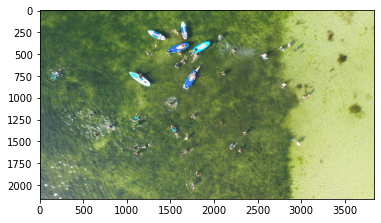

In [15]:
# view sample image; row 1
sample_path = './PART_1/PART_1/images/a_1013.jpg'

img = cv2.imread(sample_path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
plt.imshow(img)

In [16]:
# bounding boxes for row 1
bboxes = bbox_filtered_df_category1.iloc[1]['bbox']

converted_bboxes = []
for bbox in bboxes:
    W, H = img.shape[1], img.shape[0]  
    yolo_bbox = tuple(bbox)
    # https://stackoverflow.com/questions/64096953/how-to-convert-yolo-format-bounding-box-coordinates-into-opencv-format
    x,y,w,h = pbx.convert_bbox(yolo_bbox, from_type="yolo", to_type="voc", image_size=(W, H)) # convert bbox
    new_bboxes = [x,y,w,h]
    converted_bboxes.append(new_bboxes)

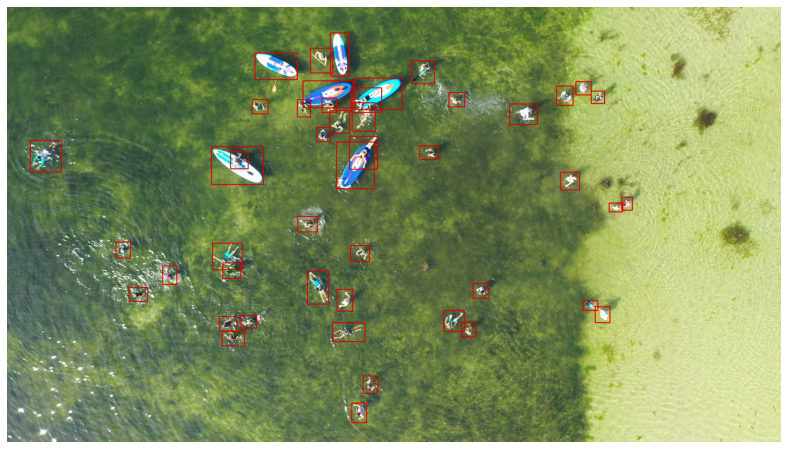

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for bbox in bboxes:
    W, H = img.shape[1], img.shape[0]  
    yolo_bbox = tuple(bbox)
    x,y,w,h = pbx.convert_bbox(yolo_bbox, from_type="yolo", to_type="voc", image_size=(W, H))
    cv2.rectangle(img,
                  (x, y), 
                  (w, h), 
                  (220, 0, 0), 3)

    
ax.set_axis_off()
ax.imshow(img)

In [18]:
class AFODataset(Dataset):
  
    def __init__(self, df, transforms=None):
        super().__init__()

        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):
        img_file = self.df['img_file'].values[index] 
        bboxes = self.df['bbox'].values[index]
        records = len(bboxes)
        
        image = cv2.imread(f'{path2images}{img_file}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        converted_bboxes = []
        for bbox in bboxes:
            W, H = image.shape[1], image.shape[0]  
            yolo_bbox = tuple(bbox)
            x,y,w,h = pbx.convert_bbox(yolo_bbox, from_type="yolo", to_type="voc", image_size=(W, H))
            new_bboxes = [x,y,w,h]
            converted_bboxes.append(new_bboxes)

        # there is only one class
        labels = torch.ones((records,), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records,), dtype=torch.int64)

        target = {}
        target['boxes'] = torch.tensor(converted_bboxes)
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return torch.tensor(image), target, img_file

In [19]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Resize(240, 320, p=1.0),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

You'll encounter the following error if you run the cell below without fixing the following [issue](https://github.com/albumentations-team/albumentations/issues/459)

Basically, in `/usr/local/lib/python3.7/dist-packages/albumentations/core/bbox_utils.py` 

replace `check_bbox` function with the code cell below and `Restart runtime`

In [ ]:
def check_bbox(bbox):
  """Check if bbox boundaries are in range 0, 1 and minimums are lesser then maximums"""
  bbox=list(bbox)
  for i in range(4):
    if (bbox[i]<0):
      bbox[i]=0
    elif (bbox[i]>1):
      bbox[i]=1
  bbox=tuple(bbox)

In [40]:
show_dataset = AFODataset(bbox_filtered_df_category1, get_train_transform())
image, target, img_file = show_dataset[0]

ValueError: ignored

# Visualize image with bounding boxes

In [20]:
show_dataset = AFODataset(bbox_filtered_df_category1, get_train_transform())
image, target, img_file = show_dataset[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [21]:
image = image.permute(1,2,0).cpu().numpy()
bbox = target['boxes'].cpu().numpy().astype(np.int32)

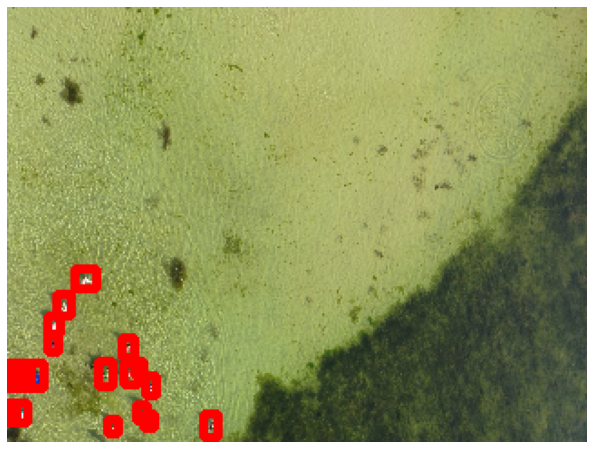

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in bbox:
    cv2.rectangle(image,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(image)

# Load model

In [24]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# Split data in train & valid

In [25]:
train_ds = bbox_filtered_df_category1[:780]
valid_ds = bbox_filtered_df_category1[780:]

print(train_ds.shape, valid_ds.shape)

(780, 3) (195, 3)


# Prepare dataloaders

In [26]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = AFODataset(train_ds, transforms=get_train_transform())
valid_dataset = AFODataset(valid_ds, transforms=get_valid_transform())

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

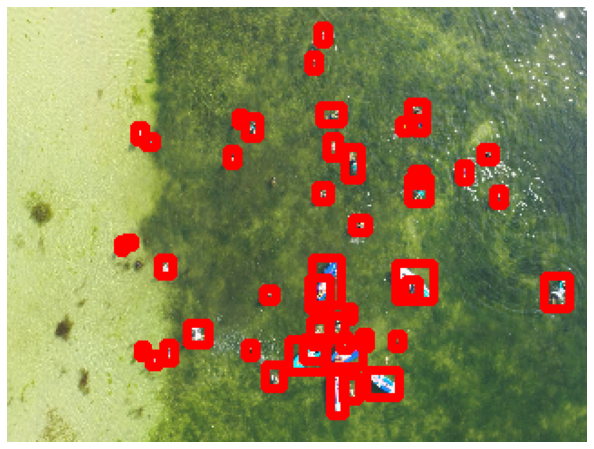

In [28]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [30]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None
scaler = torch.cuda.amp.GradScaler()

num_epochs = 2

# Run train model

In [31]:
for epoch in range(1,num_epochs+1):
  scaler = torch.cuda.amp.GradScaler()
  model.train()

  train_loss = []
  bar = tqdm(train_data_loader)
  for images, targets, image_ids in bar:
      optimizer.zero_grad()
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      
      with amp.autocast():
          loss_dict = model(images, targets)
          loss = sum(loss for loss in loss_dict.values())

      train_loss.append(loss.item())
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      
      bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')
  print(f'Epoch: {epoch}, train loss:', np.mean(train_loss))

  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTens

Epoch: 1, train loss: 1.0838263489079578


  0%|          | 0/98 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTens

Epoch: 2, train loss: 0.9539137252749151


# Eval model

In [32]:
images, targets, image_ids = next(iter(valid_data_loader))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

In [33]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [34]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [35]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

# Visualize image with bounding box using target labels

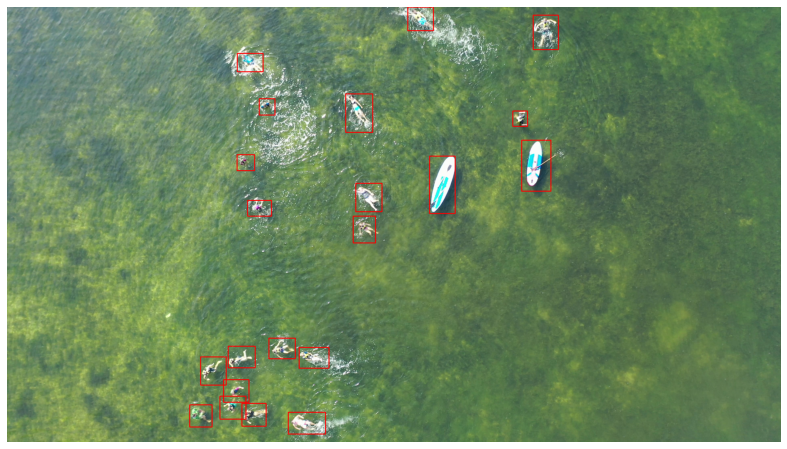

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Visualize image with bounding box using predictions

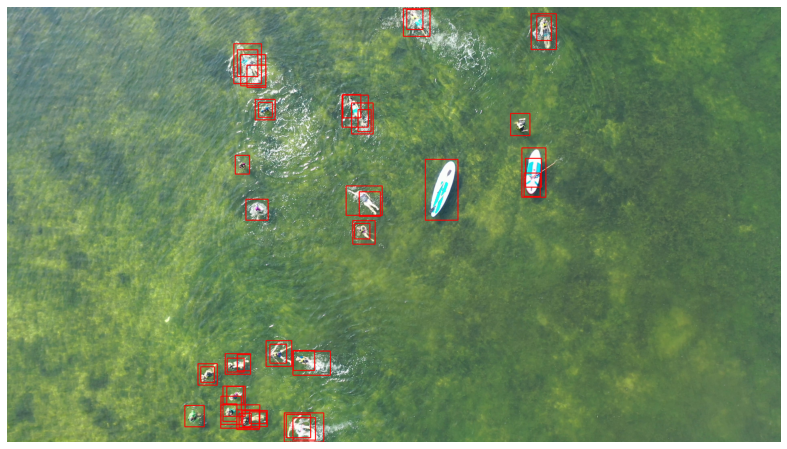

In [37]:
sample = images[3].permute(1,2,0).cpu().numpy()
pred_boxes = outputs[3]['boxes'].cpu().detach().numpy().astype(np.int32)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in pred_boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)